--------------------------------------------------------------------------------------

* Team member names: Yu-Chun Chen, Yanyu Tao
* Team member IDs: A13356506, A13961185

--------------------------------------------------------------------------------------


# Mini-project 2, DSC 170, Spring 2019
## Advanced Geopandas: spatial join and geoprocessing


In this mini-project, you will explore several common geospatial computations. The goal is to practice with different types of requests against a single layer, and then work on joining several data layers using real data. The goal is to demonstrate your geopandas mastery, and also to show that you can discover datasets and critically evaluate metadata. 

For each dataset that you found and used, explore its metadata and provide a brief description (about 3 sentences): indicate its title, URL, number of records, coordinate reference system, the manner in which it was compiled (as far as you can tell from the metadata), and any data quality considerations, especially those that may influence geometric processing. 

There will be one relatively simple warm-up problem, and one larger and very real problem that the City of San Diego is struggling with. The best creative solutions to the second one will be demonstrated when Scale-SD folks come here to give an invited talk.

Note that the upload file size limit has been removed from the datahub, so you should be able to upload your data.



In [1]:
%matplotlib inline 
import geopandas as gpd
import pandas as pd

# add packages as needed

--------------------------------------------------------------------------------------
__Problem 1__. 

In an administrative boundaries map of California (find it as a GeoJSON or a shapefile on one of the web sites), find a county named San Diego and return its CRS, polygon coordinates, area (in sq miles), bounding box (in latitude and longitude), and a list of neighboring counties. 

Generally speaking, this will be a function to return geometric characteristics and neighbors of any polygon in an input dataframe (input_gdf) with a given name (poly_name) in a specific column (poly_name_field). Most lilely, in the database you find there will be a unique "San Diego" record - but it won't harm to do dissolve, just in case.

```python
def poly_geometry(input_gdf, poly_name_field, poly_name):

# YOUR CODE HERE

    return crs, poly_coords, area, bounding_box, neighbors
```



### Solution for problem 1: code and dataset description:

In [ ]:
# problem 1 solution stud code
def poly_geometry(input_gdf, poly_name_field, poly_name):

# YOUR CODE HERE

    return crs, poly_coords, area, bounding_box, neighbors

In [16]:
input_gdf = gpd.read_file('CA_Counties_TIGER2016.shp')
poly_name = 'San Diego'
poly_name_field = 'NAME'

In [2]:
# problem 1 solution stud code
def poly_geometry(input_gdf, poly_name_field, poly_name):
    selected = input_gdf.copy().loc[input_gdf[poly_name_field] == poly_name]
    
    #crs
    crs = selected.crs
    
    #poly_coords
    poly_coords = selected.geometry#.iloc[0]
    
    #area
    area = selected.geometry.iloc[0].area * 3.86102 * 10**(-7)
    
    #bounding_box
    envelope = selected.envelope
    bounding_box = envelope.to_crs('EPSG:4326')#.iloc[0]
    
    #neighbors
    df = input_gdf.copy()
    neighbors = df[df.geometry.touches(selected.iloc[0].geometry)].NAME.tolist()
    

    return crs, poly_coords, area, bounding_box, neighbors

#raise NotImplementedError()

__Problem 1 dataset description:__

The title of the dataset we used in the problem 'CA County Boundaries', which came from URL: https://data.ca.gov/dataset/ca-geographic-boundaries. The dataset includes 58 records, using the coordinate reference system coded 3857, which is a projected coordinate system used by Google Map and based on WGS84 Datum. The geography in this dataset generally reflects the boundaries of governmental units in effect as of January 1, 2016, and other legal and statistical area boundaries that have been adjusted and/or corrected since the 2010 Census.

In [ ]:
# running the function

input_gdf = gpd.read_file('  your file here  ')
poly_name_field = 'Counties'  # or whatever is in the file
poly_name = 'San Diego' # or whatever is in the file

crs,poly_coords,area,bbox,neighbors = poly_geometry(input_gdf, poly_name_field, poly_name)

print(crs)
print(poly_coords)
print(area)
print(bbox)
print(neighbors)


In [3]:
# running the function

input_gdf = gpd.read_file('CA_Counties_TIGER2016.shp')
poly_name_field = 'NAME'  # or whatever is in the file
poly_name = 'San Diego' # or whatever is in the file

crs,poly_coords,area,bbox,neighbors = poly_geometry(input_gdf, poly_name_field, poly_name)

print(crs)
print(poly_coords)
print(area)
print(bbox)
print(neighbors)

{'init': 'epsg:3857'}
8    POLYGON ((-13073075.79626082 3919158.523585408...
Name: geometry, dtype: object
6456.166796425826
8    POLYGON ((32.52883673637251 -117.6110930236377...
dtype: object
['Riverside', 'Orange', 'Imperial']


--------------------------------------------------------------------------------------

__Problem 2.__

Food choices in low and medium income (LMI) neighborhoods are limited, as these areas lack healthy food stores or other fresh food delivery mechanisms. There may be more fast food stores than fresh produce shops. Population is relatively poor, and filling the food basket with healthy options hasn't been an overwhelming priority for many households. Such areas are referred to as "food deserts". 

See these articles:
* https://www.sandiegouniontribune.com/news/data-watch/sdut-san-diego-food-deserts-2016may15-htmlstory.html (see food desert definitions here)
* https://www.npr.org/sections/thesalt/2013/03/13/174112591/how-to-find-a-food-desert-near-you
* https://www.geospatial.institute/wp-content/uploads/2018/03/Mapping-Food-Desserts-in-Southern-California-Counties.pdf 
* https://www.sandiegoreader.com/news/2018/sep/04/stringers-imperial-beach-food-desert/# (a recent one, about IB)
* https://www.kpbs.org/news/2018/mar/29/sdsu-students-take-food-deserts-national-city/
* http://newscenter.sdsu.edu/sdsu_newscenter/news_story.aspx?sid=74890 
* https://grist.org/food/americas-worst-food-deserts-map-lovers-edition/
* https://ucsdcommunityhealth.org/news/promoting-produce-consumption/

There was also a Master's thesis at UCSD: https://escholarship.org/uc/item/0s78j9g2

Don't read them all, just skim to understand the issues and get ideas.

We'll analyze the current state of food deserts, using lists of businesses that operate in San Diego, and social-demographic data from SanDAG (by census tracts). 

For the list of businesses, let's use City of San Diego tax certificates:
https://data.sandiego.gov/datasets/business-listings/. These data are current, and include lat/lon. They also include detailed NAICS codes for each business. This is the recommended dataset. We are interested in active certificates. We are also interested in types of businesses that are relevant to healthy (and unhealthy) food options. Healthy food options would include FOOD (HEALTH) SUPPLEMENT STORES, GROCERY STORES and GROCERY (EXCEPT CONVENIENCE) STORES. Unhealthy food options would include FOOD SERVICES & DRINKING PLACES, FULL-SERVICE RESTAURANTS, LIMITED-SERVICE EATING PLACES, LIMITED-SERVICE RESTAURANTS (a.k.a fast food places), BEER, WINE & LIQUOR STORES, TOBACCO STORES, CONVENIENCE STORES (a mixed bag...). We have provided this as part of the assignment. You don't need to download it, but you may if you wish.


There is also "SanDAG's point locations of business sites" in San Diego County (see metadata at http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Business&Name=BUSINESS_SITES.pdf). This is already a shapefile, so this is a plus (but note  disclaimers in the metadata). The date is 8/17/2017, i.e. not as current. Industry codes are not as detailed as NAICS in the City's dataset. 

We'll also get relevant spatial data layers from SanDAG: Promise Zone, and census tract boundaries. Note that you'll need to create a free account to access Sandag GIS data warehouse.

Descriptions of promise zones can be found at these links:
* https://www.hud.gov/sites/documents/SAN-DIEGO_ZONE_3RD.PDF
* https://www.sandiego.gov/economic-development/sdpromisezone/maps
* https://www.sandiego.gov/economic-development/sdpromisezone

To download the shapefiles, visit the SanDAG's "Maps and GIS" section:
* Promise Zone is under Business. Metadata at http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Business&Name=Promise_Zone_SD.pdf. Alternatively, you can use https://data.sandiego.gov/datasets/promise-zone/
* Census tracts are under Census. Metadata at http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Census&Name=CENSUS_TRACTS_2010.pdf. 

Social-demographic data by census tracts can be downloaded from SanDAG at https://sandag.org/index.asp?classid=26&fuseaction=home.classhome. You can try to find the data yourself - but  we also include an xlsx file with some income statistics by census tracts. 

San Diego County municipal boundaries (metadata at http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Jurisdiction&Name=Municipal_Boundaries.pdf) can be downloaded from the same GIS Data Warehouse, under the "Jurisdiction" section. Alternatively, use https://data.sandiego.gov/datasets/san-diego-boundary/ (we only need the boundary of San Diego city, so the latter is quite sufficient.)

Your tasks:

1. Download the data - promise zone, census tracts, jurisdictions (census tracts social-demographic data and businesses data are provided but you can download as well if you wish), read them into geopandas dataframes, and merge social-demographic data with tract boundaries as needed.

2. Subset the businesses (figure out, from NAICS descriptions, which businesses are likely to provide healthy food options, and which unhealthy. You can use our suggestions above but also feel free to deviate from them as long as you justify your choices.)

3. Determine census tracts intersecting with the promise zone, and all other census tracts within the boundary of San Diego.

4. For each census tract marked as belonging to the promise zone, and the other tracts within the city limits, calculate the number of healthy and not-healthy options within that tract. 

5. Compute the ratio of healthy and non-healthy options, and build a regression model showing how it depends on social-demographic characteristics, such as median income or number of people in lowest and highest income brackets. You may use sklearn on this dataframe by tracts to compute a linear regresson (as you did in DSC80. As a refresher, you may also check out https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9, https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606, https://stackoverflow.com/questions/29934083/linear-regression-on-pandas-dataframe-using-sci-kit-learn/29937049). Provide a brief description of regression results.

6. Generate a map showing the ratio of healthy and not healthy food options, and the locations of stores offering healthy food options. 

7. Extra Credit: Think of additional variables that you could bring into this analysis, and try to include them in the regression. ScaleSD is running a hackathon on this topic, and they have a good collection of data sources: https://www.scalesd.com/hackathon-2019/food-insecurity.html. 


We won't provide a skeleton for this problem. This is a much more open project than before. 


### Solution for problem 2: code, dataset descriptions, discussion of regression results:

__Problem 2 dataset descriptions:__

The title of the first dataset we used is 'Promise Zone', which came from URL: http://rdw.sandag.org/Account/gisdtview?dir=Business. The dataset includes only 1 record for San Diego, using the coordinate reference system coded 2230, which is California State Plane zone 6, over NAD83, used for San Diego. The geography in this dataset contains the area characterized by high unemployment, low educational attainment, insufficient access to healthy foods, concentrated poverty, rising crime,and the least affordable housing in the nation.

The title of the second dataset we used is 'Census_Tracts_2010', which came from URL: http://rdw.sandag.org/Account/gisdtview?dir=Census. The dataset includes 627 records, each for one tract, using the coordinate reference system coded 2230, which is California State Plane zone 6, over NAD83, used for San Diego. The geography in this dataset includes polygons representing 2010 US Census Bureau census tracts for San Diego County.

The title of the third dataset we used is 'Socio-Demographic', which came from URL: https://sandag.org/index.asp?classid=26&fuseaction=home.classhome. The dataset includes 43890 records. It includes income information for each census tract from 2011 to 2016.

The title of the fourth dataset we used is 'sd_businesses_active_since08_datasd', which came from URL: http://rdw.sandag.org/Account/gisdtview?dir=Business. The dataset includes 40208 records, each for one business. It contains the information of point locations of business sites in San Diego County.

In [2]:
promise_zone = gpd.read_file('Promise_Zone_SD.shp')
census_tract = gpd.read_file('CENSUS_TRACTS_2010.shp')
social_demo = pd.read_excel('socio-demographic.xlsx')
sd_business = pd.read_csv('sd_businesses_active_since08_datasd.csv')
#raise NotImplementedError()

In [10]:
sd_business

,account_key,account_status,account_creation_dt,cert_expiration_dt,business_owner_name,ownership_type,bus_start_dt,dba_name,naics_sector,naics_code,...,street_name,street_suffix,street_fraction,city,state,zip,suite,pmb_box,po_box,BID
0,2007009129,Active,2008-05-08,2020-04-30 23:59:59,IBERIA INC,CORP,2005-05-01 00:00:00,IBERIA INC,54,541,...,HORTENSIA,ST,NaN,SAN DIEGO,CA,92110-2945,NaN,NaN,NaN,Old Town
1,2007009143,Active,2008-05-08,2020-04-30 23:59:59,DA KINE DESIGN INC,CORP,2005-05-01 00:00:00,DA KINE DESIGN INC,23,233,...,SANTA BARBARA,ST,NaN,SAN DIEGO,CA,92107-3945,NaN,NaN,NaN,NaN
2,2007009148,Active,2008-05-08,2020-04-30 23:59:59,TDR INVESTMENTS LLC,LLC,2005-05-01 00:00:00,TDR INVESTMENTS LLC,54,541,...,CAMINITO DEL MAR SANDS,NaN,NaN,SAN DIEGO,CA,92130-2521,NaN,NaN,NaN,NaN
3,2007009201,Active,2008-05-08,2020-04-30 23:59:59,NORTHWEST VILLAGE LLC,LLC,2005-05-01 00:00:00,NORTHWEST VILLAGE LLC,54,541,...,EUCLID,AVE,NaN,SAN DIEGO,CA,92114-2221,NaN,NaN,NaN,Diamond
4,2007009359,Active,2008-05-08,2020-04-30 23:59:59,TAMI M FULLER,SOLE,2005-05-01 00:00:00,OCEAN BEACH SANDS,53,5313,...,HISTORIC DECATUR,RD,NaN,SAN DIEGO,CA,92106-6148,150,NaN,NaN,NaN
5,2007009429,Active,2008-05-08,2020-04-30 23:59:59,STONECREST LAND MANAGEMENT INC,CORP,2005-05-01 00:00:00,STONECREST LAND MANAGEMENT INC,54,541,...,OVIEDO,ST,NaN,SAN DIEGO,CA,92129-2135,NaN,NaN,NaN,NaN
6,2007009466,Active,2008-05-08,2020-04-30 23:59:59,VOICE VENTURES INCORPORATED,CORP,2005-05-01 00:00:00,VOICE VENTURES INCORPORATED,54,5416,...,SMITH CANYON,CT,NaN,SAN DIEGO,CA,92130-2738,NaN,NaN,NaN,NaN
7,2007009521,Active,2008-05-07,2019-12-31 23:59:59,"WEST COAST VENTURES I, LLC",LLC,2005-01-01 00:00:00,WEST COAST VENTURES I LLC,52,52,...,BROADWAY,NaN,NaN,SAN DIEGO,CA,92101-8595,540,NaN,NaN,Gaslamp Quarter
8,2007009524,Active,2008-05-07,2019-12-31 23:59:59,THE SCHMIDT HOLDING GROUP INC,CORP,2005-01-01 00:00:00,THE SCHMIDT HOLDING GROUP INC,55,55111,...,MIRAMAR,RD,NaN,SAN DIEGO,CA,92121-2641,102,NaN,NaN,NaN
9,2007009570,Active,2008-05-08,2020-04-30 23:59:59,SMISER FAMILY LP,CORP,2005-05-01 00:00:00,SMISER FAMILY LP,54,541,...,NaN,NaN,NaN,SAN DIEGO,CA,92138-7564,NaN,NaN,87564.0,NaN


In [11]:
social = social_demo.copy()[social_demo['YEAR'] == 2016]
social = social.pivot_table(index = 'TRACT', columns = 'INCOME GROUP', values = 'HOUSEHOLDS')

In [12]:
#step1
merged = census_tract.merge(social, on = 'TRACT')

In [13]:
#step2
healthy = ['FOOD (HEALTH) SUPPLEMENT STORES', 'GROCERY STORES', 'GROCERY (EXCEPT CONVENIENCE) STORES']
unhealthy = ['FOOD SERVICES & DRINKING PLACES', 'FULL-SERVICE RESTAURANTS', 'LIMITED-SERVICE EATING PLACES', 'LIMITED-SERVICE RESTAURANTS', 'BEER, WINE & LIQUOR STORES', 'TOBACCO STORES', 'CONVENIENCE STORES']
sd_healthy = sd_business.copy().loc[sd_business['naics_description'].isin(healthy)]
sd_unhealthy = sd_business.copy().loc[sd_business['naics_description'].isin(unhealthy)]


In [14]:
#step3
inter_promise = census_tract.copy()[census_tract.intersects(promise_zone.geometry.iloc[0])]#.plot()
not_promise = census_tract.copy()[~census_tract.intersects(promise_zone.geometry.iloc[0])]#.plot()

In [15]:
#step4
from shapely.geometry import Point
sd_healthy['geometry'] = sd_healthy.apply(lambda x: Point(x.longitude, x.latitude), axis = 1)
healthy_gdf = gpd.GeoDataFrame(sd_healthy, crs={'init':'epsg:4326'}, geometry='geometry')
healthy_gdf = healthy_gdf.to_crs({'init':'epsg:2230'})
sd_unhealthy['geometry'] = sd_unhealthy.apply(lambda x: Point(x.longitude, x.latitude), axis = 1)
unhealthy_gdf = gpd.GeoDataFrame(sd_unhealthy, crs={'init':'epsg:4326'}, geometry='geometry')
unhealthy_gdf = unhealthy_gdf.to_crs({'init':'epsg:2230'})


In [16]:
inter_promise['healthy'] = inter_promise.apply(lambda x: healthy_gdf.within(x.geometry).sum(), axis = 1)
inter_promise['unhealthy'] = inter_promise.apply(lambda x: unhealthy_gdf.within(x.geometry).sum(), axis = 1)
not_promise['healthy'] = not_promise.apply(lambda x: healthy_gdf.within(x.geometry).sum(), axis = 1)
not_promise['unhealthy'] = not_promise.apply(lambda x: unhealthy_gdf.within(x.geometry).sum(), axis = 1)

In [17]:
#step5
#social = social.pivot_table(index = 'TRACT', columns = 'INCOME GROUP', values = 'HOUSEHOLDS')
inter_promise['p-zone'] = inter_promise.apply(lambda x: 1, axis = 1)
not_promise['p-zone'] = not_promise.apply(lambda x: 0, axis = 1)
gdf = pd.concat([inter_promise, not_promise])


In [18]:
#smoothing
overall_rate = gdf.healthy.sum()/gdf.unhealthy.sum()
alpha = 10
gdf['ratio'] = (gdf.healthy + alpha * overall_rate) / (gdf.unhealthy + alpha)
merged = gdf.merge(social, on = 'TRACT')


In [19]:
#train for regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = merged.drop(["TRACT", "SHAPE_AREA", "SHAPE_LEN", "geometry", "ratio", "healthy", "unhealthy"], axis=1)
y = merged.ratio
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
lg = LinearRegression()
lg.fit(X_train, y_train)
zipped = zip(X.columns, lg.coef_)
prediction = lg.predict(X_test)
from sklearn import metrics
print('error: '+ str(np.sqrt(metrics.mean_squared_error(y_test, prediction))))

error: 0.028460059858005187


In [23]:
lg.coef_


array([ 1.16598180e-02, -5.96373781e-05,  8.46888861e-05,  2.00478306e-05,
        3.75208467e-05, -2.04225714e-05, -1.13925702e-05, -1.24306150e-05,
       -2.16389698e-05, -7.16167804e-06,  1.25931639e-05])

In [24]:
lg.intercept_

0.06676061371332306

Text(0.5,1,'Ratio of Health Food Options to Unhealthy Food Options')

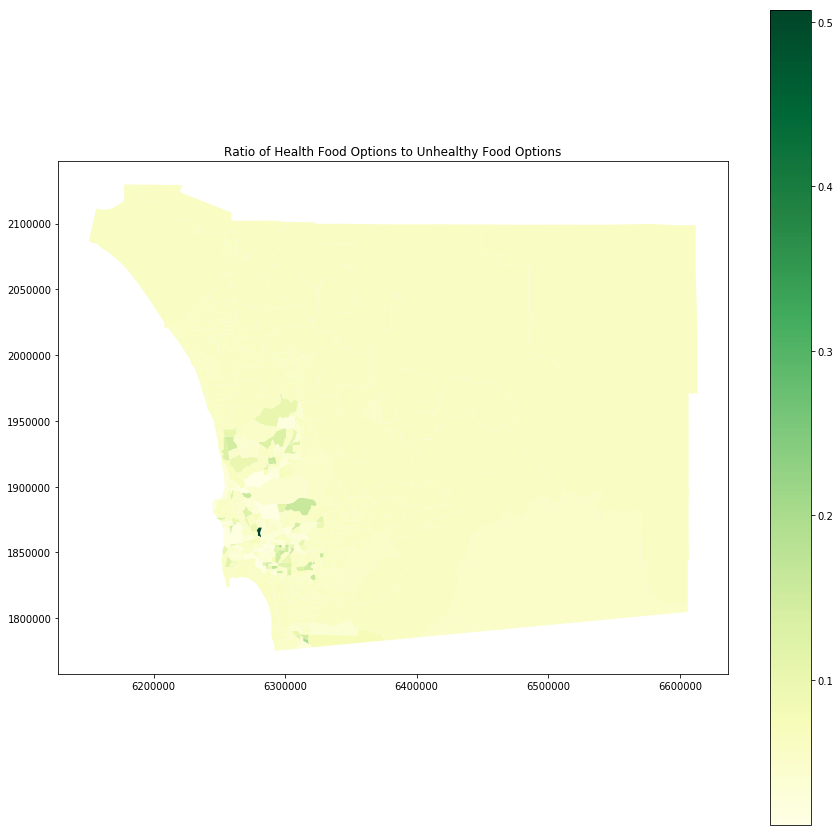

In [25]:
#step6
base = gdf.plot(figsize=(15,15), column="ratio", cmap='YlGn', legend=True)
#healthy_gdf.plot(ax=base, color='red', markersize = 4, label="Healthy Food Options")
base.set_title('Ratio of Health Food Options to Unhealthy Food Options')

The max ratio is around 0.5, while the second largest ratio falls under 0.2. We will consider the area with ratio 0.5 as outlier that is 'very healthy', and plot the rest to better visualize their ratio difference

The max ratio is around 0.5, while the second largest ratio falls under 0.2. We consider the area with ratio 0.5 as outlier that is 'very healthy', and plot the rest to better visualize their ratio difference


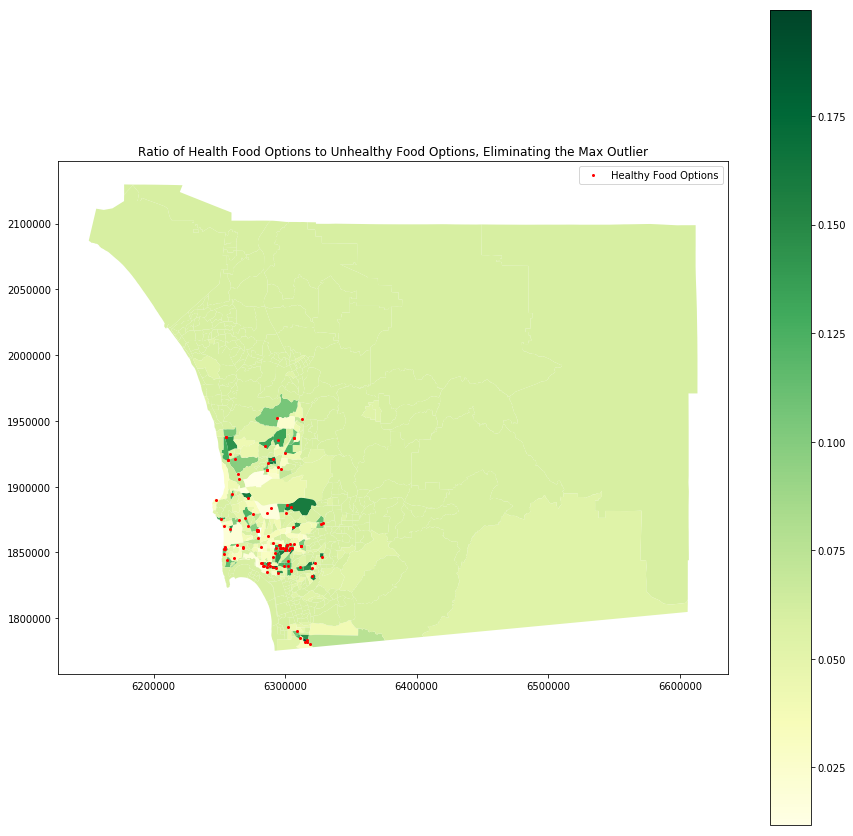

In [27]:
#the max ratio is around 0.5, while the second largest ratio falls under 0.2. We consider the area with ratio 0.5 as 
#outlier that is 'very healthy', and plot the rest to better visualize their ratio difference
copy = gdf.copy()[gdf['ratio']!= gdf.ratio.max()]
base = copy.plot(figsize=(15,15), column="ratio", cmap='YlGn', legend=True)
healthy_gdf.plot(ax=base, color='red', markersize = 4, label="Healthy Food Options")
base.legend()
base.set_title('Ratio of Health Food Options to Unhealthy Food Options, Eliminating the Max Outlier')
print('The max ratio is around 0.5, while the second largest ratio falls under 0.2. We consider the area with ratio 0.5 as outlier that is \'very healthy\', and plot the rest to better visualize their ratio difference')


__Problem 2 discussion of linear regression results:__

We use whether or not in p-zone, and population in ten different income range groups to train for regression model. With the resulting coefficients for the variables, we found that whether or not in p-zone has the most effect in predicting for the ratio of healthy food options to unhealthy food options (note that we smooth our ratio toward the overall ratio of healthy to unhealthy food options). In addition, the intercept is farely large compared to the coefficients, indicating that the variables are not very effective in prediction. This is also shown by the root mean squared error: 0.042.

## Responses to the extra credit questions:

Your text here

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 6hrs  
extracredit_timespent = 